In [81]:
from collections import Counter
import random

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.normalizers import normalizers
from tokenizers.normalizers import NFD, StripAccents, Lowercase
from tokenizers.pre_tokenizers import Whitespace

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import Trainer
from transformers import TrainerCallback

import evaluate

from datasets import load_dataset

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

In [82]:
dataset = load_dataset("dair-ai/emotion")

train_data = dataset['train']
test_data = dataset['test']
validation_data = dataset['validation']

labels = train_data.features['label'].names

In [83]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.enable_padding()
trainer = BpeTrainer(special_tokens=[
	"[UNK]" , "[PAD]"
])

normalizer = normalizers.Sequence([NFD(), StripAccents(), Lowercase()])
tokenizer.normalizer = normalizer

pre_tokenizer = Whitespace()
tokenizer.pre_tokenizer = pre_tokenizer

tokenizer.train_from_iterator(train_data['text'], trainer)

padding_idx = tokenizer.token_to_id("[PAD]")

In [84]:
def tokenization(example):
	output = tokenizer.encode(example['text'])
	return {
		"ids": output.ids,
		"type_ids": output.type_ids,
		"attention_mask": output.attention_mask
	}

train_data_tokenized = train_data.map(tokenization)
train_data_tokenized.set_format(type="torch", columns=["ids", "type_ids", "attention_mask", "label"])

validation_data_tokenized = validation_data.map(tokenization)
validation_data_tokenized.set_format(type="torch", columns=["ids", "type_ids", "attention_mask", "label"])

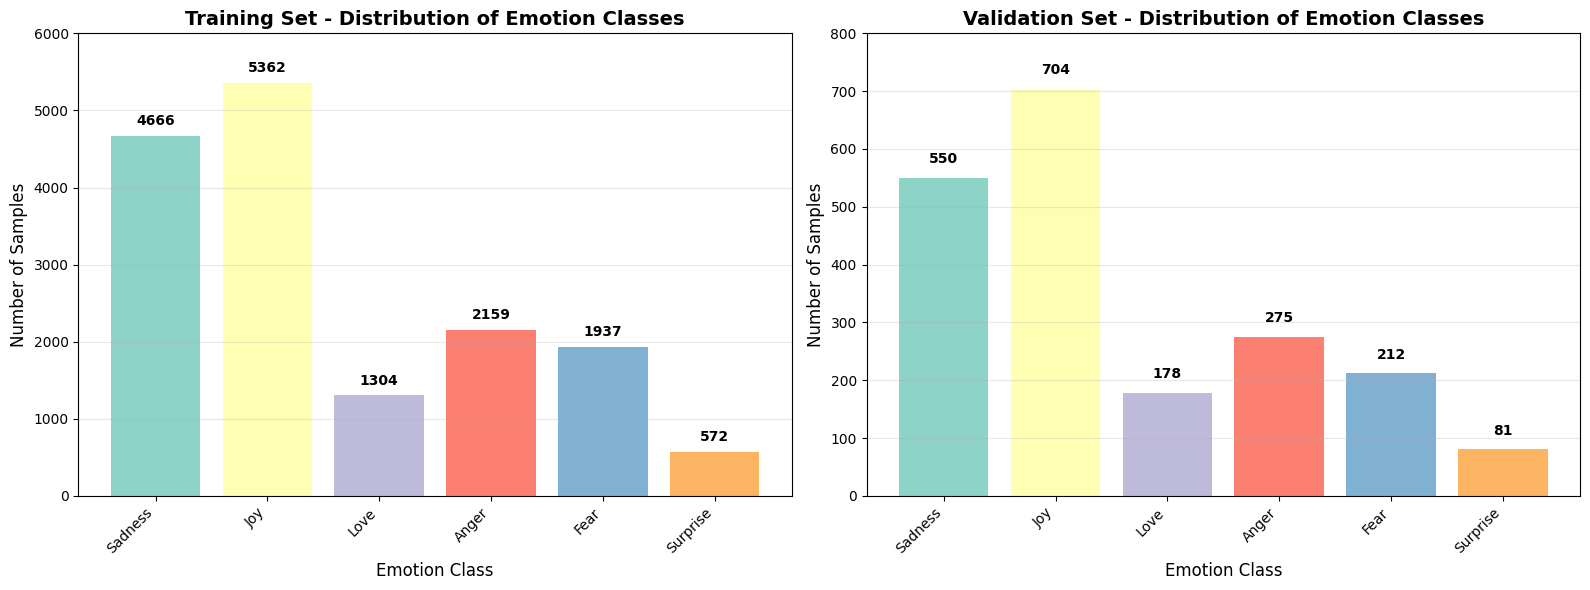

In [85]:
train_label_counts = Counter(train_data['label'])
validation_label_counts = Counter(validation_data['label'])
test_label_counts = Counter(test_data['label'])

def plot_class_distribution_combined(train_counts, val_counts, label_names):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    classes = sorted(train_counts.keys())
    train_data = [train_counts[i] for i in classes]
    val_data = [val_counts[i] for i in classes]
    colors = plt.cm.Set3(range(len(classes)))

    axes[0].bar(classes, train_data, color=colors)
    axes[0].set_xlabel('Emotion Class', fontsize=12)
    axes[0].set_ylabel('Number of Samples', fontsize=12)
    axes[0].set_title('Training Set - Distribution of Emotion Classes', fontsize=14, fontweight='bold')
    axes[0].set_xticks(classes)
    axes[0].set_xticklabels([label_names[i].capitalize() for i in classes], rotation=45, ha='right')
    axes[0].set_ylim(0, 6000)
    axes[0].grid(axis='y', alpha=0.3)

    for i, (c, count) in enumerate(zip(classes, train_data)):
        axes[0].text(c, count + 100, str(count), ha='center', va='bottom', fontweight='bold')

    axes[1].bar(classes, val_data, color=colors)
    axes[1].set_xlabel('Emotion Class', fontsize=12)
    axes[1].set_ylabel('Number of Samples', fontsize=12)
    axes[1].set_title('Validation Set - Distribution of Emotion Classes', fontsize=14, fontweight='bold')
    axes[1].set_xticks(classes)
    axes[1].set_xticklabels([label_names[i].capitalize() for i in classes], rotation=45, ha='right')
    axes[1].set_ylim(0, 800)
    axes[1].grid(axis='y', alpha=0.3)

    for i, (c, count) in enumerate(zip(classes, val_data)):
        axes[1].text(c, count + 20, str(count), ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('class_distribution_combined.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_class_distribution_combined(train_label_counts, validation_label_counts, labels)

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [87]:
class RNN(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.emb_size = emb_size

        self.embedding = nn.Embedding(self.input_size, self.emb_size, padding_idx=padding_idx)
        self.dropout_emb = nn.Dropout(0.2)
        self.rnn = nn.RNN(self.emb_size, hidden_size, num_layers=1, batch_first=True)

        self.h2o = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, X, lengths):
        emb = self.dropout_emb(self.embedding(X))
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, h_n = self.rnn(packed)

        hidden = self.dropout(h_n[0])
        logits = self.h2o(hidden)
        return logits

In [88]:
class GRU(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.emb_size = emb_size

        self.embedding = nn.Embedding(self.input_size, self.emb_size, padding_idx=padding_idx)
        self.dropout_emb = nn.Dropout(0.2)
        self.rnn = nn.GRU(self.emb_size, hidden_size, num_layers=1, batch_first=True)

        self.h2o = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, X, lengths):
        emb = self.dropout_emb(self.embedding(X))
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, h_n = self.rnn(packed)

        hidden = self.dropout(h_n[0])
        logits = self.h2o(hidden)
        return logits

In [89]:
class LSTM(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.emb_size = emb_size

        self.embedding = nn.Embedding(self.input_size, self.emb_size, padding_idx=padding_idx)
        self.dropout_emb = nn.Dropout(0.2)
        self.rnn = nn.LSTM(self.emb_size, hidden_size, num_layers=1, batch_first=True)

        self.h2o = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, X, lengths):
        emb = self.dropout_emb(self.embedding(X))
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, c_n) = self.rnn(packed)
        if self.rnn.bidirectional:
            hidden = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            hidden = h_n[-1]

        hidden = self.dropout(hidden)
        logits = self.h2o(hidden)
        return logits

In [90]:
label_counts = Counter(train_data['label'])
total = sum(label_counts.values())
class_weights = torch.tensor([total / (len(label_counts) * label_counts[i]) for i in range(len(label_counts))]).to(device)

In [91]:
def collate_fn(batch):
	ids = [torch.as_tensor(x["ids"], dtype=torch.long) for x in batch]
	attn = [torch.as_tensor(x["attention_mask"], dtype=torch.long) for x in batch]
	labels = torch.as_tensor([x["label"] for x in batch], dtype=torch.long)

	ids = torch.nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=padding_idx)
	attn = torch.nn.utils.rnn.pad_sequence(attn, batch_first=True, padding_value=0)

	lengths = attn.sum(dim=1)
	return {
		"input_ids": ids,
		"attention_mask": attn,
		"labels": labels,
		"lengths": lengths,
	}

In [92]:
train_data_loader = DataLoader(train_data_tokenized, batch_size=32, collate_fn=collate_fn, shuffle=True)
validation_data_loader = DataLoader(validation_data_tokenized, batch_size=32, collate_fn=collate_fn, shuffle=False)

In [93]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)

    for batch, data in enumerate(dataloader):
        X = data['input_ids'].to(device)
        y = data['labels'].to(device)
        lengths = data['lengths'].to(device)

        preds = model(X, lengths)
        loss = loss_fn(preds, y)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    avg_loss = total_loss / num_batches
    return avg_loss

def eval_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    num_batches = len(dataloader)

    with torch.no_grad():
        for data in dataloader:
            X = data['input_ids'].to(device)
            y = data['labels'].to(device)
            lengths = data['lengths'].to(device)

            preds = model(X, lengths)
            pred_labels = torch.argmax(preds, dim=1)
            loss = loss_fn(preds, y)
            total_loss += loss.item()

            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / num_batches

    accuracy = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0) * 100
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0) * 100

    return avg_loss, accuracy, f1, precision, recall

In [94]:
def train_model(model, model_name, train_loader, val_loader, loss_fn, optimizer, num_epochs=5):
    print(f"Training {model_name} Model")

    train_losses = []
    validation_losses = []
    validation_accuracies = []
    validation_f1_scores = []
    validation_precisions = []
    validation_recalls = []

    for epoch in range(num_epochs):
        train_loss = train_loop(train_loader, model, loss_fn, optimizer)
        val_loss, val_acc, val_f1, val_prec, val_rec = eval_loop(val_loader, model, loss_fn)

        print(f"Epoch: {epoch + 1}, Training Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
              f"Val F1: {val_f1:.2f}%, Val Prec: {val_prec:.2f}%, Val Rec: {val_rec:.2f}%")

        train_losses.append(train_loss)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_acc)
        validation_f1_scores.append(val_f1)
        validation_precisions.append(val_prec)
        validation_recalls.append(val_rec)

    return {
        'train_losses': train_losses,
        'val_losses': validation_losses,
        'val_accuracies': validation_accuracies,
        'val_f1_scores': validation_f1_scores,
        'val_precisions': validation_precisions,
        'val_recalls': validation_recalls,
        'model': model
    }

In [95]:
input_size = tokenizer.get_vocab_size()
emb_size = 256
hidden_size = 128
output_size = len(set(train_data['label']))
num_epochs = 5

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

results = {}

In [96]:
rnn_model = RNN(input_size, emb_size, hidden_size, output_size).to(device)
rnn_optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=2e-3)
results['RNN'] = train_model(rnn_model, 'RNN', train_data_loader, validation_data_loader, loss_fn, rnn_optimizer, num_epochs)

Training RNN Model
Epoch: 1, Training Loss: 1.7760, Val Loss: 1.6605, Val Acc: 33.05%, Val F1: 34.01%, Val Prec: 41.69%, Val Rec: 33.05%
Epoch: 2, Training Loss: 1.3993, Val Loss: 1.1590, Val Acc: 48.00%, Val F1: 48.94%, Val Prec: 61.24%, Val Rec: 48.00%
Epoch: 3, Training Loss: 0.9849, Val Loss: 0.8941, Val Acc: 72.20%, Val F1: 72.72%, Val Prec: 73.80%, Val Rec: 72.20%
Epoch: 4, Training Loss: 0.7800, Val Loss: 0.7501, Val Acc: 79.55%, Val F1: 79.53%, Val Prec: 80.21%, Val Rec: 79.55%
Epoch: 5, Training Loss: 0.6470, Val Loss: 0.6921, Val Acc: 82.35%, Val F1: 82.42%, Val Prec: 82.83%, Val Rec: 82.35%


In [97]:
gru_model = GRU(input_size, emb_size, hidden_size, output_size).to(device)
gru_optimizer = torch.optim.AdamW(gru_model.parameters(), lr=2e-3)
gru_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

results['GRU'] = train_model(gru_model, 'GRU', train_data_loader, validation_data_loader, gru_loss_fn, gru_optimizer, num_epochs)

Training GRU Model
Epoch: 1, Training Loss: 1.3237, Val Loss: 0.4950, Val Acc: 81.80%, Val F1: 81.89%, Val Prec: 82.89%, Val Rec: 81.80%
Epoch: 2, Training Loss: 0.3288, Val Loss: 0.2288, Val Acc: 90.70%, Val F1: 90.81%, Val Prec: 91.24%, Val Rec: 90.70%
Epoch: 3, Training Loss: 0.1659, Val Loss: 0.2247, Val Acc: 92.45%, Val F1: 92.56%, Val Prec: 93.01%, Val Rec: 92.45%
Epoch: 4, Training Loss: 0.1105, Val Loss: 0.2655, Val Acc: 92.50%, Val F1: 92.59%, Val Prec: 92.95%, Val Rec: 92.50%
Epoch: 5, Training Loss: 0.0802, Val Loss: 0.2531, Val Acc: 92.70%, Val F1: 92.82%, Val Prec: 93.13%, Val Rec: 92.70%


In [98]:
lstm_model = LSTM(input_size, emb_size, hidden_size, output_size).to(device)
lstm_optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=2e-3)
lstm_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

results['LSTM'] = train_model(lstm_model, 'LSTM', train_data_loader, validation_data_loader, lstm_loss_fn, lstm_optimizer, num_epochs)

Training LSTM Model
Epoch: 1, Training Loss: 1.4432, Val Loss: 0.7588, Val Acc: 77.15%, Val F1: 77.11%, Val Prec: 77.63%, Val Rec: 77.15%
Epoch: 2, Training Loss: 0.4542, Val Loss: 0.3481, Val Acc: 88.75%, Val F1: 88.88%, Val Prec: 89.40%, Val Rec: 88.75%
Epoch: 3, Training Loss: 0.2160, Val Loss: 0.2964, Val Acc: 90.75%, Val F1: 90.84%, Val Prec: 91.16%, Val Rec: 90.75%
Epoch: 4, Training Loss: 0.1317, Val Loss: 0.3463, Val Acc: 91.10%, Val F1: 91.15%, Val Prec: 91.47%, Val Rec: 91.10%
Epoch: 5, Training Loss: 0.0959, Val Loss: 0.3287, Val Acc: 92.05%, Val F1: 92.13%, Val Prec: 92.34%, Val Rec: 92.05%


In [99]:
def predict(text, model, tokenizer):
    model.eval()

    encoding = tokenizer.encode(text)
    ids = torch.tensor([encoding.ids], dtype=torch.long).to(device)
    lengths = torch.tensor([len(encoding.ids)], dtype=torch.long).to(device)

    with torch.no_grad():
        logits = model(ids, lengths)
        probs = torch.softmax(logits, dim=1).squeeze(0)
        pred_label = torch.argmax(probs).item()

    print(f"\nInput text: {text}")
    print(f"Predicted Emotion: {labels[pred_label].upper()} (class {pred_label})")
    return pred_label

In [100]:
for _ in range(5):
    sample = random.choice(test_data)
    text, true_label = sample["text"], sample["label"]
    print(f"\nActual label: {labels[true_label].upper()} (class {true_label})")

    model = lstm_model
    predict(text, model, tokenizer)


Actual label: JOY (class 1)

Input text: i feel terrific in every one of them
Predicted Emotion: JOY (class 1)

Actual label: LOVE (class 2)

Input text: i smiled at him feeling his longing and said maybe later buddy but i have to make lunch now
Predicted Emotion: LOVE (class 2)

Actual label: FEAR (class 4)

Input text: i feel a little nervous i go to the gym
Predicted Emotion: FEAR (class 4)

Actual label: JOY (class 1)

Input text: i feel like it might just be ok
Predicted Emotion: JOY (class 1)

Actual label: JOY (class 1)

Input text: i am going to actively learn more about these genres and or practice them so i can feel what i should feel as a dancer gt fearless courageous confident phew
Predicted Emotion: JOY (class 1)


In [101]:
bert_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=6)
bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

bert_model.config.id2label = labels

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
def tokenize_fn(example):
    return bert_tokenizer(example['text'], truncation = True)

tokenized_dataset = dataset.map(tokenize_fn, batched = True)
data_collator = DataCollatorWithPadding(bert_tokenizer)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [103]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        'accuracy': accuracy_metric.compute(predictions=predictions, references=labels)['accuracy'],
        'f1': f1_metric.compute(predictions=predictions, references=labels, average='weighted')['f1'],
        'precision': precision_metric.compute(predictions=predictions, references=labels, average='weighted')['precision'],
        'recall': recall_metric.compute(predictions=predictions, references=labels, average='weighted')['recall'],
    }

In [104]:
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.val_f1s = []
        self.val_precisions = []
        self.val_recalls = []
        self.epochs = []

    def on_log(self, args, state, control, logs = None, **kwargs):
        if logs is None:
            return

        if "loss" in logs and not any(k.startswith("eval_") for k in logs.keys()):
            self.train_losses.append(logs["loss"])

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is None:
            return

        self.epochs.append(state.epoch)
        self.val_losses.append(metrics.get("eval_loss", 0))
        self.val_accuracies.append(metrics.get("eval_accuracy", 0) * 100)
        self.val_f1s.append(metrics.get("eval_f1", 0) * 100)
        self.val_precisions.append(metrics.get("eval_precision", 0) * 100)
        self.val_recalls.append(metrics.get("eval_recall", 0) * 100)

metrics_callback = MetricsCallback()

In [105]:
training_args = TrainingArguments("test-trainer", eval_strategy="epoch", logging_strategy = "epoch", report_to="none")

trainer = Trainer(
    bert_model,
    training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    processing_class=bert_tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]
)

In [106]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.405900,0.195789,0.932500,0.933467,0.938454,0.932500
2,0.151600,0.174252,0.941000,0.940326,0.942073,0.941000
3,0.110500,0.191808,0.944500,0.944438,0.945027,0.944500


TrainOutput(global_step=6000, training_loss=0.22266102600097656, metrics={'train_runtime': 743.8991, 'train_samples_per_second': 64.525, 'train_steps_per_second': 8.066, 'total_flos': 1019041047667008.0, 'train_loss': 0.22266102600097656, 'epoch': 3.0})

In [107]:
results['BERT'] = {
    'train_losses' : metrics_callback.train_losses,
    'val_losses' : metrics_callback.val_losses,
    'val_accuracies' : metrics_callback.val_accuracies,
    'val_f1_scores' : metrics_callback.val_f1s,
    'val_precisions' : metrics_callback.val_precisions,
    'val_recalls' : metrics_callback.val_recalls
}

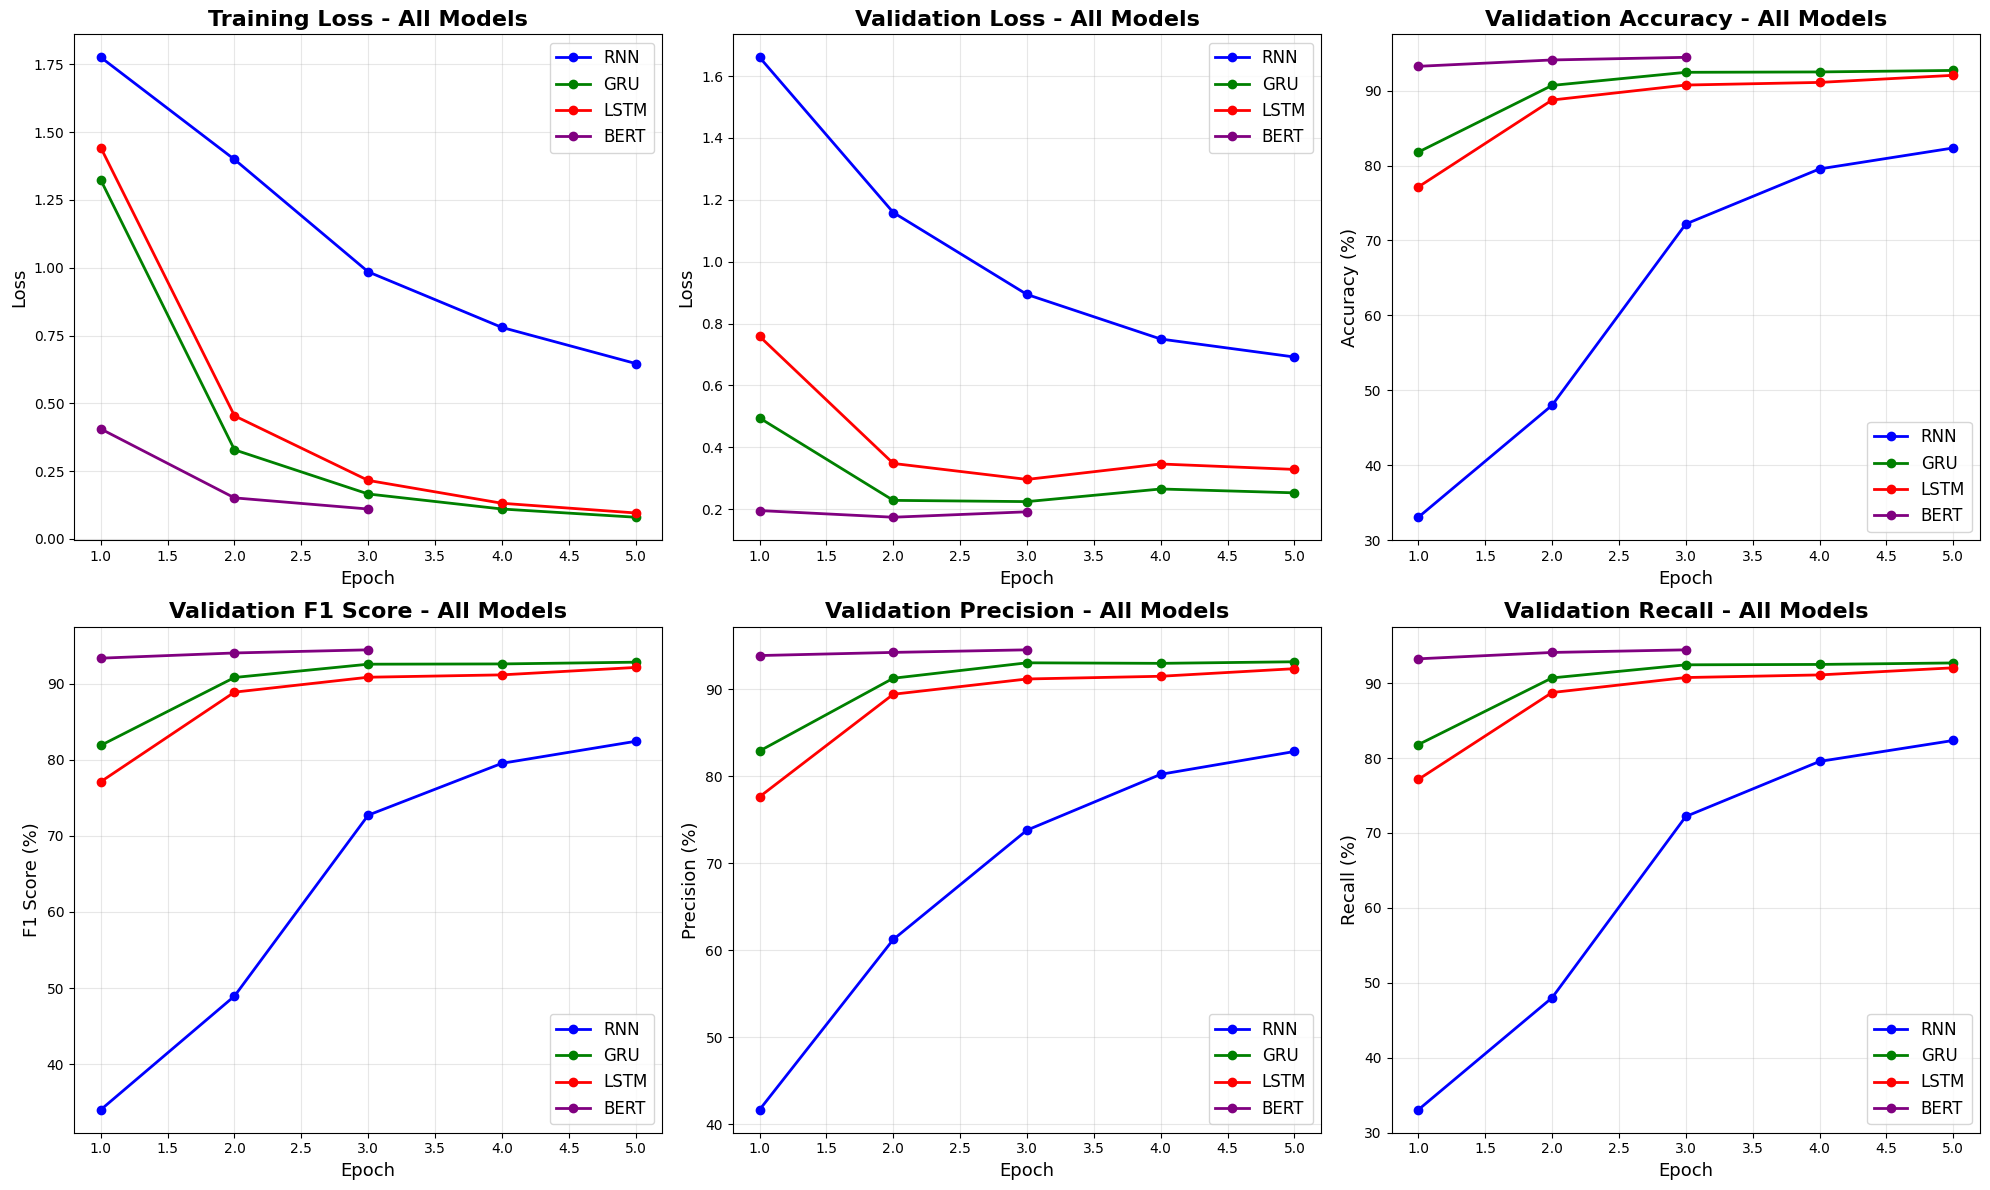

In [108]:
def plot_all_models_final_comparison(results):
    colors = {'RNN': 'blue', 'GRU': 'green', 'LSTM': 'red', 'BERT': 'purple'}

    metrics_config = [
        ('train_losses', 'Training Loss', 'Loss'),
        ('val_losses', 'Validation Loss', 'Loss'),
        ('val_accuracies', 'Validation Accuracy', 'Accuracy (%)'),
        ('val_f1_scores', 'Validation F1 Score', 'F1 Score (%)'),
        ('val_precisions', 'Validation Precision', 'Precision (%)'),
        ('val_recalls', 'Validation Recall', 'Recall (%)')
    ]

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes_flat = axes.flatten()

    for idx, (metric_key, title, ylabel) in enumerate(metrics_config):
        ax = axes_flat[idx]

        for model_name, model_results in results.items():
            if metric_key in model_results:
                epochs = range(1, len(model_results[metric_key]) + 1)
                ax.plot(epochs, model_results[metric_key], marker='o',
                       label=model_name, color=colors.get(model_name, 'black'),
                       linewidth=2, markersize=6)

        ax.set_title(f"{title} - All Models", fontsize=16, fontweight='bold')
        ax.set_xlabel("Epoch", fontsize=13)
        ax.set_ylabel(ylabel, fontsize=13)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig('all_models_final_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
plot_all_models_final_comparison(results)